# development_stage

In [1]:
import logging
import typing as t
from functools import lru_cache
from logging import log

import networkx as nx
import owlready2
from scipy import sparse as sp

import numpy as np
import torch
import pandas as pd
import pandas_gbq
from google.cloud import bigquery

In [2]:
# Query template format
query_format = """
    select {column_name}, count(*) as num_cells 
    from `cas_2024_05_16_dataset.human_cellariumgpt_extract__extract_cell_info`
    group by {column_name}
    order by num_cells desc
"""

In [3]:
def get_ancestors_csr_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> sp.csr_matrix:
    """Returns a sparse matrix representation of ancestors.

    .. note:
        The matrix element (i, j) = 1 iff j is an ancetor of i.
    """
    n_nodes = len(graph.nodes)

    row = []
    col = []
    data = []

    for name, self_idx in names_to_idx_map.items():
        row.append(self_idx)
        col.append(self_idx)
        data.append(1)
        for ancestor_name in nx.ancestors(graph, name):
            ancestor_idx = names_to_idx_map[ancestor_name]
            row.append(self_idx)
            col.append(ancestor_idx)
            data.append(1)

    ancestors_csr_matrix = sp.csr_matrix((data, (row, col)), shape=(n_nodes, n_nodes))
    return ancestors_csr_matrix

In [4]:
def get_shortest_distances_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> np.ndarray:
    """Returns a sparse matrix representation of shortest distances.

    .. note:
        The matrix element (i, j) = d iff d is the shortest distance between i and j.
    """
    n_nodes = len(graph.nodes)

    distance_matrix = np.full((n_nodes, n_nodes), np.inf)

    for target, value in dict(nx.all_pairs_shortest_path_length(graph)).items():
        for source, distance in value.items():
            source_idx = names_to_idx_map[source]
            target_idx = names_to_idx_map[target]
            distance_matrix[source_idx, target_idx] = distance
            distance_matrix[target_idx, source_idx] = distance

    return distance_matrix

## extract

In [5]:
query_name = "development_stage_ontology_term_id"
names_counts = pandas_gbq.read_gbq(
    query_format.format(column_name=query_name),
    project_id="dsp-cell-annotation-service",
)
names_counts

/home/yordabay/anaconda3/envs/ontology/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,development_stage_ontology_term_id,num_cells
0,unknown,2645739
1,HsapDv:0000095,1768880
2,HsapDv:0000144,1768121
3,HsapDv:0000123,1411475
4,HsapDv:0000136,1396533
...,...,...
169,HsapDv:0000219,2240
170,HsapDv:0000223,976
171,HsapDv:0000221,930
172,HsapDv:0000220,867


In [6]:
query_label = "development_stage"
labels_counts = pandas_gbq.read_gbq(
    query_format.format(column_name=query_label),
    project_id="dsp-cell-annotation-service",
)
labels_counts

/home/yordabay/anaconda3/envs/ontology/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,development_stage,num_cells
0,unknown,2645739
1,80 year-old and over human stage,1768880
2,50-year-old human stage,1768121
3,29-year-old human stage,1411475
4,42-year-old human stage,1396533
...,...,...
169,93-year-old human stage,2240
170,97-year-old human stage,976
171,95-year-old human stage,930
172,94-year-old human stage,867


How many different ontologies are used for `development_stage`?

In [7]:
set([value[0] for value in names_counts[query_name].str.split(":")])

{'HsapDv', 'unknown'}

## ontology

In [8]:
# Used in CZ CELLxGENE schema v5:
# https://github.com/chanzuckerberg/single-cell-curation/blob/main/schema/5.0.0/schema.md
OWL_PATH = "http://purl.obolibrary.org/obo/hsapdv.owl"

# only keep nodes with the following prefix when parsing CL ontology
PREFIX = "HsapDv_"

# the 'life cycle stage' node
LIFE_CYCLE_STAGE_NODE = "HsapDv:0000000"

# the 'life cycle' node
LIFE_CYCLE_NODE = "HsapDv:0000001"

# relationships we need
PARTOF_RELATIONSHIP = "BFO_0000050"  # part_of

In [9]:
ontology = owlready2.get_ontology(OWL_PATH).load()

In [10]:
all_classes = list(ontology.classes())

In [11]:
# only keep CL classes with a singleton label
classes = list(
    _class for _class in all_classes if _class.name.startswith(PREFIX) and len(_class.label) == 1
)

names = [_class.name.replace("_", ":") for _class in classes]
labels = [str(_class.label[0]) for _class in classes]
assert len(set(names)) == len(classes)
# assert len(set(labels)) == len(classes)

In [12]:
# these are the labels that are not unique
non_unique_labels = []
for i in range(len(labels) - 1):
    if labels[i] in labels[i + 1 :]:
        non_unique_labels.append(labels[i])
non_unique_labels

['infant stage',
 'adult stage',
 'young adult stage',
 'middle aged stage',
 '1-month-old stage']

In [13]:
extract_names_to_labels_map = dict(zip(names_counts[query_name], labels_counts[query_label]))

In [14]:
classes_set = set(classes)
names_to_labels_map = {name: label for name, label in zip(names, labels)}
names_to_idx_map = {name: idx for idx, name in enumerate(names)}
# labels_to_names_map = {label: name for name, label in zip(names, labels)}
# labels_to_idx_map = {label: idx for idx, label in enumerate(labels)}
idx_to_names_map = {idx: name for idx, name in enumerate(names)}
idx_to_labels_map = {idx: label for idx, label in enumerate(labels)}

Are all `development_stage`s covered by the ontology tree?

In [15]:
set(names_counts[query_name]) - set(names)

{'unknown'}

In [17]:
# build a networkx graph from CL
graph = nx.DiGraph(name="CL graph")

for _class in classes:
    graph.add_node(_class.name.replace("_", ":"))

for self_class in classes:
    # parents
    for parent_class in ontology.get_parents_of(self_class):
        if parent_class not in classes_set:
            continue
        graph.add_edge(parent_class.name.replace("_", ":"), self_class.name.replace("_", ":"))
    # children
    for child_class in ontology.get_children_of(self_class):
        if child_class not in classes_set:
            continue
        graph.add_edge(self_class.name.replace("_", ":"), child_class.name.replace("_", ":"))
    # part of
    for prop in self_class.get_class_properties():
        if PARTOF_RELATIONSHIP in prop.name:
            for related_term in prop[self_class]:
                if related_term.name.startswith(PREFIX):
                    graph.add_edge(related_term.name.replace("_", ":"), self_class.name.replace("_", ":"))
    # deprecated terms (WHY???!!)
    if "deprecated" in [prop.name for prop in self_class.get_class_properties()]:
        for prop in self_class.get_class_properties():
            if "consider" in prop.name:
                for substitute in prop[self_class]:
                    substitute = str(substitute)
                    if substitute.startswith(PREFIX):
                        graph.add_edge(substitute, self_class.name.replace("_", ":"))

In [18]:
ancestors_matrix = get_ancestors_csr_matrix(graph, names_to_idx_map).toarray()
ancestors_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 1]])

In [19]:
shortest_distances_matrix = get_shortest_distances_matrix(graph, names_to_idx_map)
shortest_distances_matrix = np.where(ancestors_matrix, shortest_distances_matrix, np.inf)
shortest_distances_matrix

array([[ 0., inf, inf, ..., inf, inf, inf],
       [ 1.,  0., inf, ..., inf, inf, inf],
       [ 1.,  2.,  0., ..., inf, inf, inf],
       ...,
       [ 1.,  2., inf, ...,  0., inf, inf],
       [ 1.,  3., inf, ...,  1.,  0., inf],
       [ 1.,  4., inf, ...,  2.,  1.,  0.]])

In [25]:
labels.index("15-year-old stage")

110

In [21]:
labels[110]

'15-year-old stage'

In [24]:
[labels[idx] for idx in ancestors_matrix[110].nonzero()[0]]

['life cycle stage',
 'life cycle',
 '15-year-old stage',
 '15-19 year-old',
 'prime adult stage',
 'adult stage',
 'young adult stage',
 'postnatal stage']

Only leave nodes that exist in the data and their ancestors.

In [27]:
extract_names_set = set(names_counts[query_name]) - set(["unknown"])
extract_idx = [idx for name, idx in names_to_idx_map.items() if name in extract_names_set]
assert len(extract_idx) == len(extract_names_set)
len(extract_idx)

173

In [28]:
new_extract_idx = ancestors_matrix[extract_idx].any(axis=0).nonzero()[0].tolist()
new_extract_idx = [idx for idx in new_extract_idx if idx_to_names_map[idx] not in {LIFE_CYCLE_NODE, LIFE_CYCLE_STAGE_NODE}]
len(new_extract_idx)

191

In [29]:
new_names = [idx_to_names_map[idx] for idx in new_extract_idx]
new_labels = [idx_to_labels_map[idx] for idx in new_extract_idx]

In [30]:
new_shortest_distances_matrix = shortest_distances_matrix[new_extract_idx][:, new_extract_idx]
# new_longest_distances_matrix = longest_distances_matrix[new_extract_idx][:, new_extract_idx]
new_ancestors_matrix = ancestors_matrix[new_extract_idx][:, new_extract_idx]

In [31]:
torch.save({
        "names": new_names,
        "labels": new_labels,
        "shortest_distances_matrix": torch.tensor(new_shortest_distances_matrix, dtype=torch.float32),
        # "longest_distances_matrix": torch.tensor(new_longest_distances_matrix, dtype=torch.float32),
        "ancestors_matrix": torch.tensor(new_ancestors_matrix, dtype=torch.int32),
    },
    "development_stage_ontology_data.pt"
)

<Axes: xlabel='development_stage'>

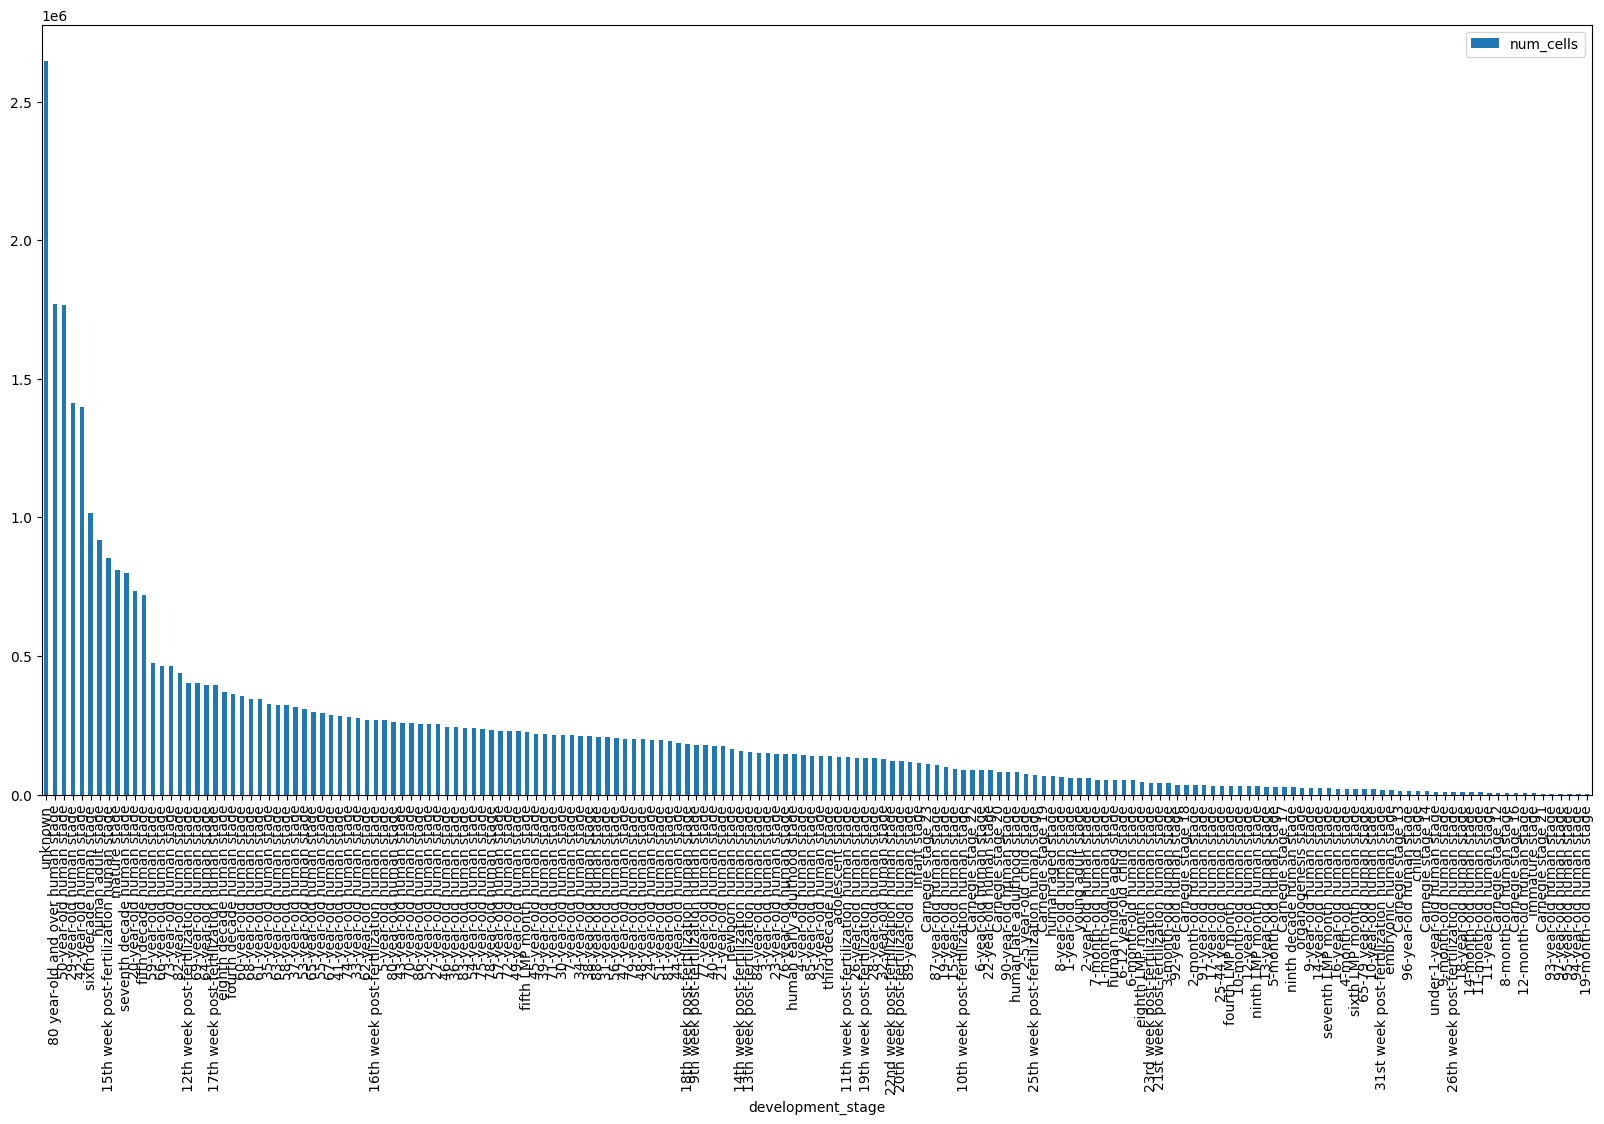

In [74]:
labels_counts.plot.bar(x=query_label, y="num_cells", figsize=(20, 10))